Epoch 10/150, Loss: 0.063970, Val Loss: 0.018067
Epoch 20/150, Loss: 0.074597, Val Loss: 0.010648
Epoch 30/150, Loss: 0.034042, Val Loss: 0.012543
Epoch 40/150, Loss: 0.011643, Val Loss: 0.007667
Epoch 50/150, Loss: 0.007185, Val Loss: 0.014354
Epoch 60/150, Loss: 0.007036, Val Loss: 0.021768
Epoch 70/150, Loss: 0.006716, Val Loss: 0.019909
Epoch 80/150, Loss: 0.008634, Val Loss: 0.019623
Epoch 90/150, Loss: 0.007108, Val Loss: 0.018204
Epoch 100/150, Loss: 0.005649, Val Loss: 0.017521
Epoch 110/150, Loss: 0.005714, Val Loss: 0.017371
Epoch 120/150, Loss: 0.007473, Val Loss: 0.019875
Epoch 130/150, Loss: 0.006223, Val Loss: 0.014774
Epoch 140/150, Loss: 0.005499, Val Loss: 0.015186
Epoch 150/150, Loss: 0.006285, Val Loss: 0.016562
Test Loss: 0.016562
Test MAPE: 1.68%
Test RMSE: 23.89
Test Accuracy: 98.32%


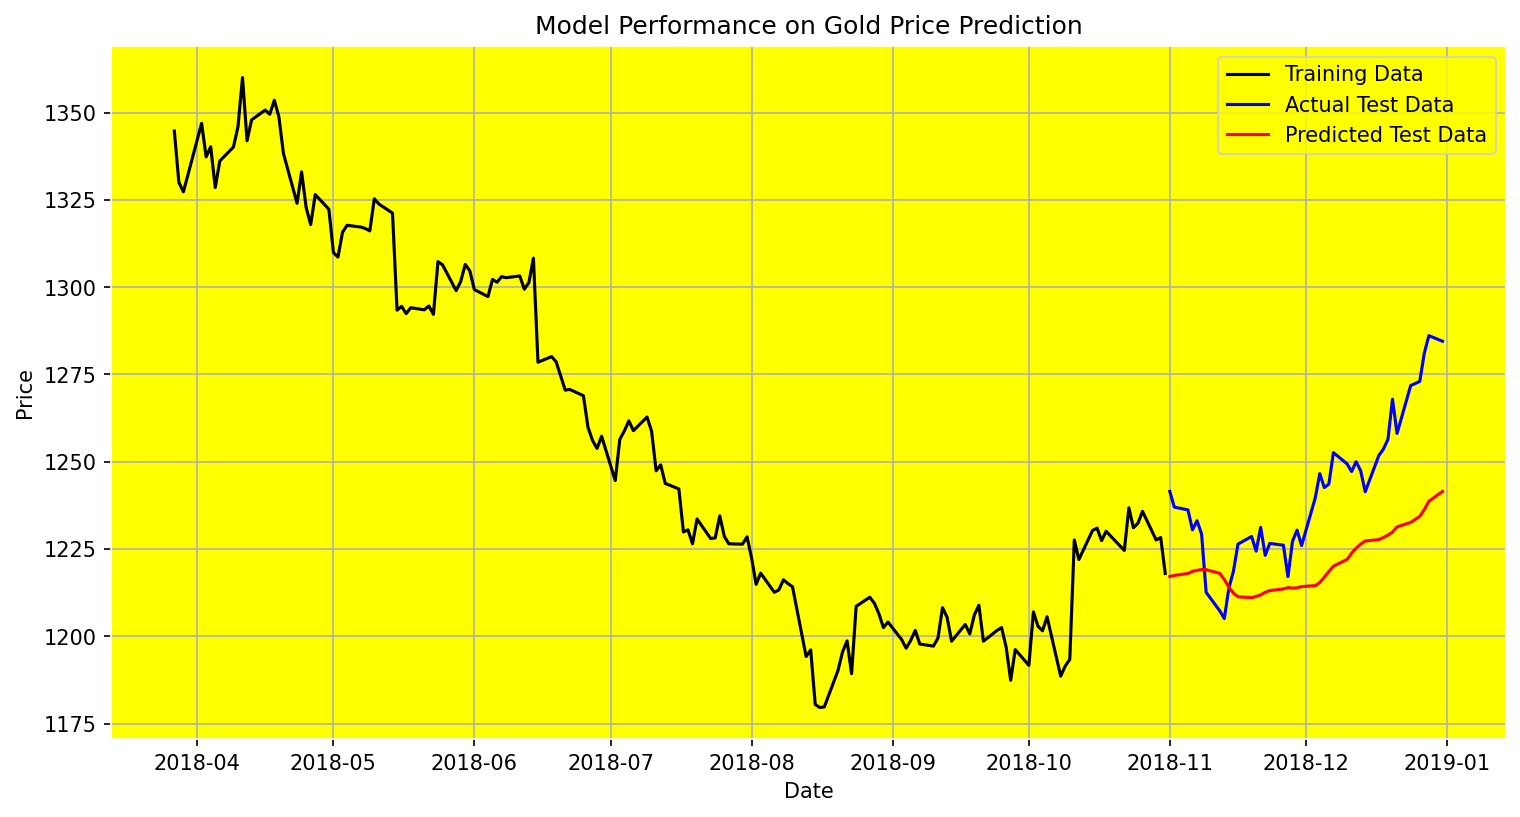

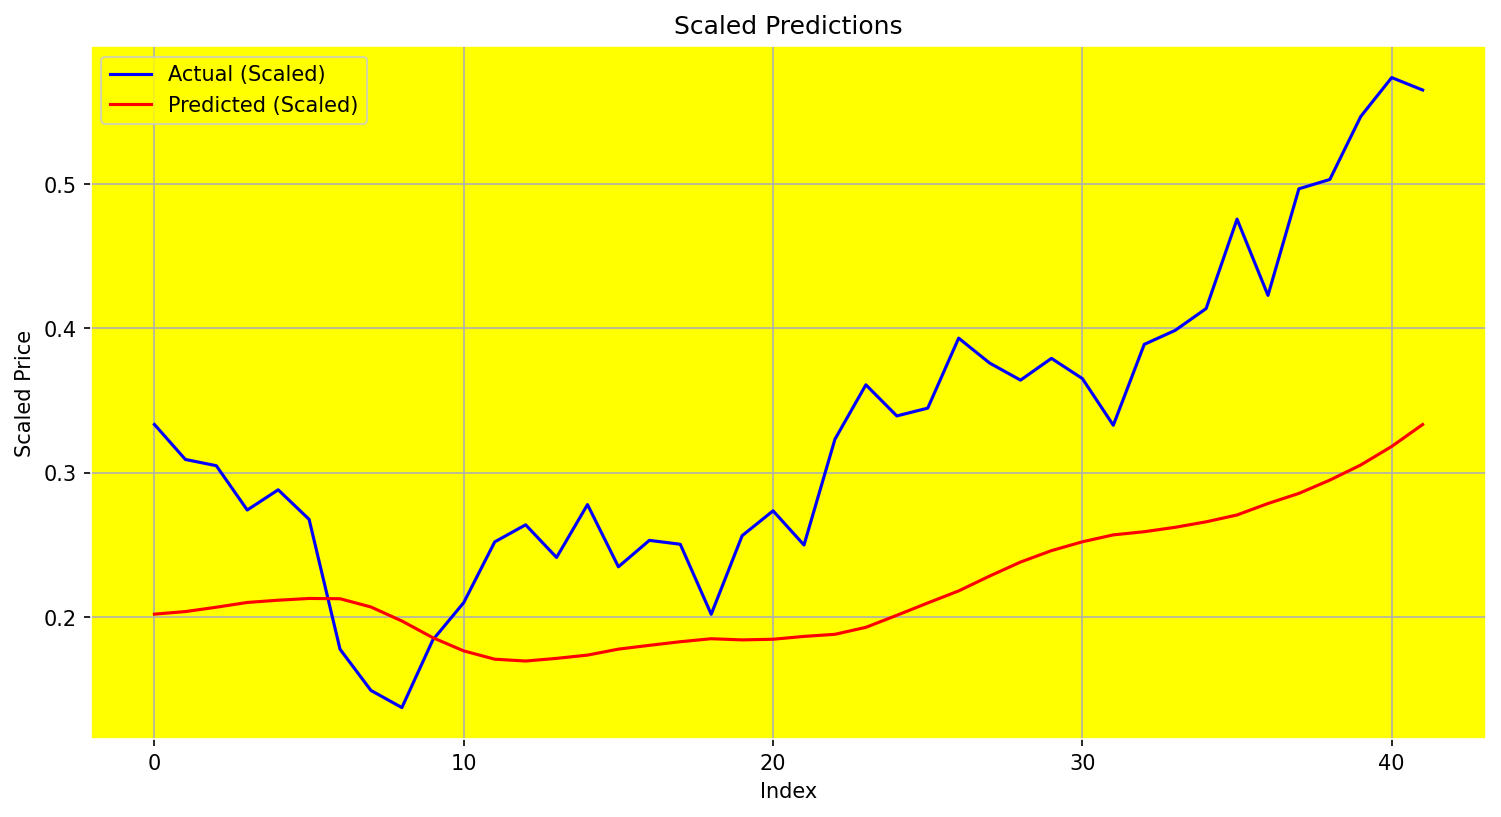

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load and Prepare Data
df = pd.read_csv('Gold Price_Year 2018.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Splitting data into training and test sets
# Updated to include both November and December
test_size = df[df.Date.dt.month.isin([11, 12])].shape[0]
window_width = 60

# Data Scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

# Prepare training data
train_data = df.Price[:-test_size]
train_data_scaled = scaler.transform(train_data.values.reshape(-1, 1))

X_train, y_train = [], []
for i in range(window_width, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - window_width:i, 0])
    y_train.append(train_data_scaled[i, 0])

# Prepare test data
test_data = df.Price[-(test_size + window_width):]
test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

X_test, y_test = [], []
for i in range(window_width, len(test_data_scaled)):
    X_test.append(test_data_scaled[i - window_width:i, 0])
    y_test.append(test_data_scaled[i, 0])

# Convert to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape for PyTorch LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters())

# Train the Model
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_test_tensor)
            val_loss = criterion(val_output, y_test_tensor)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')

# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.6f}')

# Convert predictions and actual values back to original scale
y_pred_np = y_pred.detach().cpu().numpy()
y_test_np = y_test_tensor.detach().cpu().numpy()

y_test_true = scaler.inverse_transform(y_test_np)
y_test_pred = scaler.inverse_transform(y_pred_np)

# Calculate metrics on unscaled data
MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100
Accuracy = 100 - MAPE

print(f'Test MAPE: {MAPE:.2f}%')
print(f'Test RMSE: {RMSE:.2f}')
print(f'Test Accuracy: {Accuracy:.2f}%')

# Prepare data for plotting
train_data_inv = scaler.inverse_transform(train_data_scaled[window_width:])

# Flatten the arrays for plotting
train_data_inv = train_data_inv.flatten()
y_test_true = y_test_true.flatten()
y_test_pred = y_test_pred.flatten()

# Extract dates for plotting
train_dates = df['Date'].iloc[window_width:len(train_data_inv) + window_width].reset_index(drop=True)
test_dates = df['Date'].iloc[-(len(y_test_true)):].reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(train_dates, train_data_inv, color='black', label='Training Data')
plt.plot(test_dates, y_test_true, color='blue', label='Actual Test Data')
plt.plot(test_dates, y_test_pred, color='red', label='Predicted Test Data')

plt.title('Model Performance on Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Diagnostic Plot: Scaled Data
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(y_test_np.flatten(), label='Actual (Scaled)', color='blue')
plt.plot(y_pred_np.flatten(), label='Predicted (Scaled)', color='red')
plt.title('Scaled Predictions')
plt.xlabel('Index')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.show()